In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact
from scipy.stats import norm
import os
from collections import Counter
from scipy.stats import binomtest
from scipy.stats import spearmanr,pearsonr

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

def parse_table(i):
    return [int(x) for x in i.replace("[", "").replace("]", "").split(",")]

d_abrev = {"LiangSteinNeuron":"FC exc. neur.", "FetalChondrocytes":"F chond.", "SertoliMale":"FG sertoli", "preGC_IIaFemale":"FG preGC IIa",\
          "NeuralFemale":"FG neur.", "FetalGonadImmuneFemale":"FG immune", "VIP":"AC VIP inh. neur.", "LiangSteinProgenitor":"FC prog.",\
          "AdultHeartVentricularCardiomyocyte":"AH cardiomyo.", "AdultLoopOfHenle":"AK loop of henle", "FetalBrainNeurGlioblast_CB_VZ":"FCB glioblast",\
         "AdultProximalTubule":"AK prox. tub.", "FetalLeydigMale":"FG leydig", "SST":"AC SST inh neur.", "KosoyRoussosControlMicroglia":"AC microglia",\
         "FetalBrainFloorPlate":"FB fl. plate", "FetalArterialECs":"FH endoth.", "ASCT":"AC astro.", "FetalBrainCOP":"FB COP",\
         "AMY":"AA neur.", "PVALB":"AC PVALB inh neur.", "ITL23":"AC L2-3 IT neur.", "FetalBrainNeurCB_GNP_IPC_1":"FB inter. prog.", "FetalBrainNeurDAergic":"FB DA neur.",\
          "OGC":"AC Oligo.", "D1Pu":"AP D1 inh neur.", "FetalBrainNeurSerotonergic":"FB 5-HT neur.", "FetalBrainNeurDRG_2":"FS DRG neur.",\
          "FetalHeartPericytes":"FH peri.", "FetalHeartEndocardium":"FH endocard.", "FetalHeartCardiacFibroblasts":"FH fibro.", "FetalBrainNeurPurkinje_6":"FCB Purk. inh neur.",\
          "AdultHeartSmoothMuscle":"AH smooth musc.", "FetalBrainRoofPlate":"FB ro. plate"}

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
os.listdir("PerGene_Windows_TestBGS")

['AdultHeartSmoothMuscle',
 'AdultHeartVentricularCardiomyocyte',
 'AdultLoopOfHenle',
 'AdultProximalTubule',
 'AMY',
 'ASCT',
 'D1Pu',
 'FetalArterialECs',
 'FetalBrainCOP',
 'FetalBrainFloorPlate',
 'FetalBrainNeurCB_GNP_IPC_1',
 'FetalBrainNeurDAergic',
 'FetalBrainNeurDRG_2',
 'FetalBrainNeurGlioblast_CB_VZ',
 'FetalBrainNeurPurkinje_6',
 'FetalBrainNeurSerotonergic',
 'FetalBrainRoofPlate',
 'FetalChondrocytes',
 'FetalGonadImmuneFemale',
 'FetalHeartCardiacFibroblasts',
 'FetalHeartEndocardium',
 'FetalHeartPericytes',
 'FetalLeydigMale',
 'ITL23',
 'KosoyRoussosControlMicroglia',
 'LiangSteinNeuron',
 'LiangSteinProgenitor',
 'NeuralFemale',
 'OGC',
 'PGW_BGS_PerGene_NonCod_PhyloP447_MAFCut0.25_WS25000_SpecSup250.csv.gz',
 'PGW_BGS_PerGene_NonCod_PhyloP447_MAFCut0.25_WS50000_SpecSup250.csv.gz',
 'PGW_BGS_PerGene_NPNR_NonCod_PhyloP447_MAFCut0.25_WS25000_SpecSup250.csv.gz',
 'PGW_BGS_PerGene_NPNR_NonCod_PhyloP447_MAFCut0.25_WS50000_SpecSup250.csv.gz',
 'PGW_BGS_PerWindow_NonCod_P

In [11]:
cell_type = "LiangSteinNeuron"

dfw = pd.read_csv("PerGene_Windows_TestBGS/" + cell_type + "/PGW_BGS_PerWindow_NonCod_Dl" + cell_type + "_abs_logfc_All_MAFCut0.25_WS25000_SpecSup0.csv.gz")
df = pd.read_csv("PerGene_Windows_TestBGS/" + cell_type + "/PGW_BGS_PerGene_NonCod_Dl" + cell_type + "_abs_logfc_All_MAFCut0.25_WS25000_SpecSup0.csv.gz")

#df = df[(df["Number Fixed Variants"] > 100) & (df["Number Polymorphic Variants"] > 50)]

df["Stat"] = -np.log10(df["Fisher exact p-value"])*np.sign(df["alpha"])
dfw["Stat"] = -np.log10(dfw["Fisher exact p-value"])*np.sign(dfw["alpha"])

df2 = df[df["Proportion"] == 0.6]
dfw2 = dfw[dfw["Proportion"] == 0.6]
dfw2 = dfw2[dfw2["ShufOrReal"] == "Real"]
new = []

for gene in np.unique(dfw2["Term"]):
    dfw2g = dfw2[dfw2["Term"] == gene]
    new.append([gene, np.mean(dfw2g["Stat"])])
dff = pd.DataFrame(new).set_index(0)
dff.columns = ["Window Mean"]
dff = dff.join(df2.set_index("Term"))
dff = dff.dropna()

PearsonRResult(statistic=0.6590969161497957, pvalue=0.0)
SignificanceResult(statistic=0.7293111134939849, pvalue=0.0)


<Axes: xlabel='Window Mean', ylabel='Stat'>

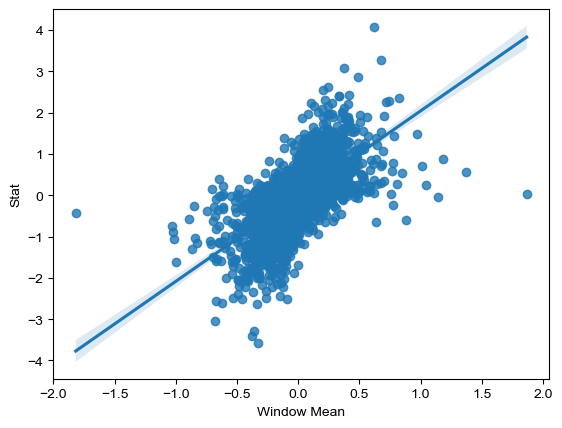

In [12]:
print(pearsonr(dff["Window Mean"], dff["Stat"]))
print(spearmanr(dff["Window Mean"], dff["Stat"]))
sns.regplot(x = dff["Window Mean"], y = dff["Stat"])

PearsonRResult(statistic=0.6872163472439228, pvalue=0.0)
SignificanceResult(statistic=0.7567031815416052, pvalue=0.0)


<Axes: xlabel='Window Mean', ylabel='Stat'>

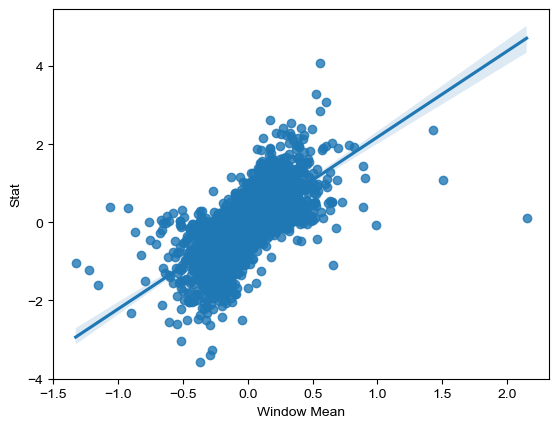

In [10]:
#This is for shuffling the positions
dff = dff.dropna()
print(pearsonr(dff["Window Mean"], dff["Stat"]))
print(spearmanr(dff["Window Mean"], dff["Stat"]))

sns.regplot(x = dff["Window Mean"], y = dff["Stat"])

In [19]:
dfw.sort_values("Stat")

,Term,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion,Window,ShufOrReal,Stat
264391,VWC2L,0.0170,69,0.1765,22,0.000067,0.015037,1.000000,0.985311,-30.911765,1.601,"[[0, 69], [6, 16]]","[[0, 69], [7, 15]]",0.7,chr2:213922921-213947921,Real,-4.177155
138198,LRRC3B,-0.1150,73,0.3100,30,0.000103,0.027897,0.999991,0.972565,-9.743421,0.828,"[[4, 69], [11, 19]]","[[4, 69], [12, 18]]",0.6,chr3:26581564-26606564,ShuffledPositions,-3.989235
195804,PTBP2,0.2350,72,0.5800,13,0.000121,0.007813,0.999998,0.992445,-51.616071,1.511,"[[1, 71], [5, 8]]","[[1, 71], [6, 7]]",0.6,chr1:96552938-96577938,ShuffledPositions,-3.918694
180078,PCSK6,-0.3590,112,0.3230,29,0.000142,0.002573,0.999983,0.997468,-6.536129,0.973,"[[9, 103], [11, 18]]","[[9, 103], [12, 17]]",0.6,chr15:101467405-101492405,Real,-3.848832
2019,ACVR2A,0.1980,80,0.8400,17,0.000163,0.000513,0.999994,0.999504,-23.286364,2.547,"[[2, 78], [6, 11]]","[[2, 78], [7, 10]]",0.6,chr2:147682760-147707760,Real,-3.787919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99840,GLRA2,0.5130,51,-0.2430,12,0.000193,0.002351,0.000193,0.002351,0.948328,-0.182,"[[47, 4], [4, 8]]","[[47, 4], [5, 7]]",0.6,chrX:14629938-14654938,Real,3.713637
60956,DCC,0.1000,95,-0.3630,39,0.000191,0.002660,0.000146,0.002660,0.802856,-0.045,"[[52, 43], [7, 32]]","[[52, 43], [8, 31]]",0.8,chr18:53146203-53171203,Real,3.719114
225558,SLITRK6,0.9405,54,-0.2800,32,0.000107,0.000143,0.000095,0.000143,0.854067,-0.113,"[[44, 10], [12, 20]]","[[44, 10], [13, 19]]",0.6,chr13:86266283-86291283,Real,3.971187
213806,SCN9A,0.1950,73,-0.1300,35,0.000057,0.000169,0.000045,0.000169,0.849432,0.054,"[[44, 29], [6, 29]]","[[44, 29], [7, 28]]",0.8,chr2:166350553-166375553,ShuffledPositions,4.244336


In [20]:
0.000095*274296/3/2

4.34302

In [17]:
dfw = pd.read_csv("PerGene_Windows_TestBGS/PGW_BGS_PerWindow_NonCod_PhyloP447_MAFCut0.25_WS25000_SpecSup250.csv.gz")
df = pd.read_csv("PerGene_Windows_TestBGS/PGW_BGS_PerGene_NonCod_PhyloP447_MAFCut0.25_WS25000_SpecSup250.csv.gz")

#df = df[(df["Number Fixed Variants"] > 100) & (df["Number Polymorphic Variants"] > 50)]

df["Stat"] = -np.log10(df["Fisher exact p-value"])*np.sign(df["alpha"])
dfw["Stat"] = -np.log10(dfw["Fisher exact p-value"])*np.sign(dfw["alpha"])

df2 = df[df["Proportion"] == 0.6]
dfw2 = dfw[dfw["Proportion"] == 0.6]
dfw2 = dfw2[dfw2["ShufOrReal"] == "ShuffledPositions"]
new = []

for gene in np.unique(dfw2["Term"]):
    dfw2g = dfw2[dfw2["Term"] == gene]
    new.append([gene, np.mean(dfw2g["Stat"])])
dff = pd.DataFrame(new).set_index(0)
dff.columns = ["Window Mean"]
dff = dff.join(df2.set_index("Term"))
dff = dff.dropna()

PearsonRResult(statistic=0.5570376075702294, pvalue=0.0)
SignificanceResult(statistic=0.6389243354113013, pvalue=0.0)


<Axes: xlabel='Window Mean', ylabel='Stat'>

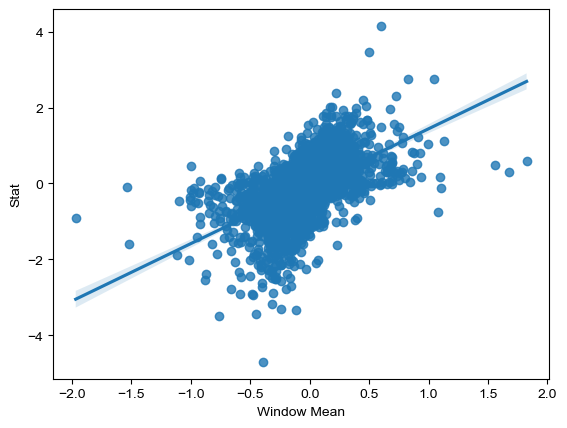

In [16]:
print(pearsonr(dff["Window Mean"], dff["Stat"]))
print(spearmanr(dff["Window Mean"], dff["Stat"]))
sns.regplot(x = dff["Window Mean"], y = dff["Stat"])

PearsonRResult(statistic=0.5746150622405886, pvalue=0.0)
SignificanceResult(statistic=0.6585621279579625, pvalue=0.0)


<Axes: xlabel='Window Mean', ylabel='Stat'>

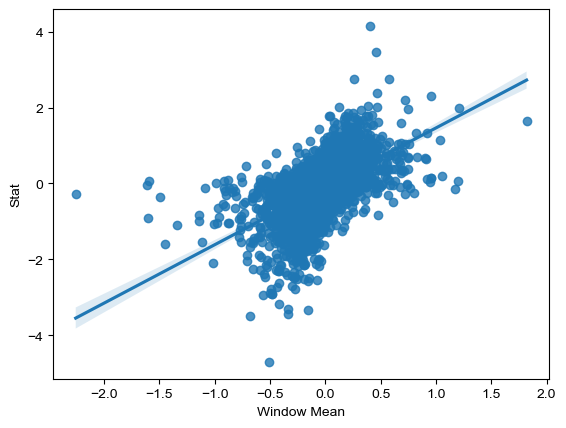

In [18]:
#This is for shuffling the positions
dff = dff.dropna()
print(pearsonr(dff["Window Mean"], dff["Stat"]))
print(spearmanr(dff["Window Mean"], dff["Stat"]))

sns.regplot(x = dff["Window Mean"], y = dff["Stat"])

In [44]:
pli = pd.read_csv("gnomad.v4.1.constraint_metrics.tsv", sep = "\t")
pli = pli.dropna()
pli = pli[pli["lof.pLI"] > 0.9]
keep_pli = pli["gene"]

syngo = list(pd.read_csv("SYNGO.txt", sep = "\t", header = None)[0])

In [108]:
#dfw = pd.read_csv("Windows_BGS/PerGeneWindowsTestBGS_PerWindow_NonCod_PhyloP447_MAFCut0.25_WindowSize50000_SpecSup250_PhyloPCut-100_PhastConsCut-1.csv")
#df = pd.read_csv("Windows_BGS/PerGeneWindowsTestBGS_PerGene_NonCod_PhyloP447_MAFCut0.25_WindowSize50000_SpecSup250_PhyloPCut-100_PhastConsCut-1.csv")

dfw = pd.read_csv("Windows_BGS/PerGeneWindowsTestBGS_PerWindow_NonCod_DlLiangSteinNeuron_abs_logfc_All_MAFCut0.25_WindowSize50000_SpecSup0_PhyloPCut-100_PhastConsCut-1.csv")
df = pd.read_csv("Windows_BGS/PerGeneWindowsTestBGS_PerGene_NonCod_DlLiangSteinNeuron_abs_logfc_All_MAFCut0.25_WindowSize50000_SpecSup0_PhyloPCut-100_PhastConsCut-1.csv")

#df = df[(df["Number Fixed Variants"] > 100) & (df["Number Polymorphic Variants"] > 50)]
#df = df[df["Term"].isin(keep_pli)]
#dfw = dfw[dfw["Term"].isin(keep_pli)]

#df = df[df["Term"].isin(syngo)]
#dfw = dfw[dfw["Term"].isin(syngo)]

df["Stat"] = -np.log10(df["Fisher exact p-value"])*np.sign(df["alpha"])
dfw["Stat"] = -np.log10(dfw["Fisher exact p-value"])*np.sign(dfw["alpha"])

df2 = df[df["Proportion"] == 0.8]
dfw2 = dfw[dfw["Proportion"] == 0.8]

shuf_var = []
real_var = []
genes = []
num_windows = []
#shuf_cvar = []
#real_cvar = []
for gene in np.unique(dfw2["Term"]):
    genes.append(gene)
    dfw2g = dfw2[dfw2["Term"] == gene]
    dfw2gr = dfw2g[dfw2g["ShufOrReal"] == "Real"]
    dfw2gs = dfw2g[dfw2g["ShufOrReal"] == "ShuffledPositions"]
    num_windows.append(len(dfw2gs.index))
    real_var.append(np.var(dfw2gr["Stat"]))
    shuf_var.append(np.var(dfw2gs["Stat"]))
    
    #real_cvar.append(np.var(dfw2gr["Stat"])/np.mean(dfw2gr["Stat"]))
    #shuf_cvar.append(np.var(dfw2gs["Stat"]))


KeyboardInterrupt



In [111]:
dfw2.sort_values("Stat").tail(50)

,Term,Median Fixed PhyloP,Number Fixed Variants,Median Polymorphic PhyloP,Number Polymorphic Variants,Fisher exact p-value,MWU p-value,Fisher exact p-value; alt greater,MWU p-value; alt greater,alpha,Cutoff,"[[dc1, du1], [pc1, pu1]]","[[dc2, du2], [pc2, pu2]]",Proportion,Window,ShufOrReal,Stat
50582,DAD1,0.024266,244,0.015261,58,0.001676,0.010111,0.001047,0.005055,0.661249,0.030950,"[[103, 141], [11, 47]]","[[103, 141], [12, 46]]",0.8,chr14:22427244-22477244,Real,2.775671
39395,CHORDC1,0.019795,231,0.014117,105,0.001638,0.105500,0.001002,0.052750,0.583218,0.029973,"[[85, 146], [20, 85]]","[[85, 146], [21, 84]]",0.8,chr11:90628901-90678901,Real,2.785672
181178,SATB1,0.019715,234,0.015122,97,0.001627,0.030403,0.000999,0.015201,0.589984,0.030261,"[[89, 145], [19, 78]]","[[89, 145], [20, 77]]",0.8,chr3:18694959-18744959,ShuffledPositions,2.788533
28346,CACNA2D3,0.020968,55,0.010846,15,0.001541,0.004597,0.001189,0.002298,0.893429,0.017820,"[[36, 19], [2, 13]]","[[36, 19], [3, 12]]",0.8,chr3:54525344-54525344,ShuffledPositions,2.812102
121031,MAGEB16,0.020808,117,0.012511,23,0.001513,0.017634,0.001031,0.008817,0.817797,0.017607,"[[67, 50], [4, 19]]","[[67, 50], [5, 18]]",0.8,chrX:35571260-35621260,Real,2.820122
124601,MCC,0.021681,201,0.011472,25,0.001497,0.019698,0.000994,0.009849,0.802617,0.020145,"[[106, 95], [4, 21]]","[[106, 95], [5, 20]]",0.8,chr5:113185968-113235968,ShuffledPositions,2.824645
68273,FAM169B,0.024589,225,0.016508,85,0.001482,0.014278,0.000855,0.007139,0.617816,0.036652,"[[87, 138], [16, 69]]","[[87, 138], [17, 68]]",0.8,chr15:98487937-98537937,Real,2.829054
101792,JAG1,0.030433,146,0.018374,63,0.001340,0.002531,0.000913,0.001265,0.673735,0.038017,"[[63, 83], [12, 51]]","[[63, 83], [13, 50]]",0.8,chr20:11004756-11054756,Real,2.872965
186971,SLA,0.026605,225,0.017690,111,0.001310,0.029857,0.000784,0.014929,0.581190,0.044665,"[[85, 140], [22, 89]]","[[85, 140], [23, 88]]",0.8,chr8:133078830-133128830,Real,2.882695
147992,PACRGL,0.023880,125,0.012521,34,0.001297,0.007982,0.000923,0.003991,0.766986,0.023519,"[[63, 62], [6, 28]]","[[63, 62], [7, 27]]",0.8,chr4:20727257-20777257,Real,2.887152


In [110]:
0.000007*78457

0.549199

In [93]:
x = pd.DataFrame([list(i) for i in zip(real_var, shuf_var, genes, num_windows)]).dropna()
x["Dif"] = x[0] - x[1]
x.sort_values("Dif")


,0,1,2,3,Dif
1581,0.025852,2.600663,GJD4,2,-2.574811
2269,0.019884,2.515651,MAN1A2,3,-2.495767
2391,0.448460,2.223195,MNS1,3,-1.774736
3878,0.237830,1.891560,TCP11,3,-1.653730
2354,0.137161,1.623346,MFSD1,3,-1.486185
...,...,...,...,...,...
2133,2.187202,0.072894,LINGO1,7,2.114308
3102,2.351162,0.036269,PTH2R,3,2.314893
3801,2.730672,0.257331,SVEP1,4,2.473341
2962,3.210598,0.134597,PNOC,3,3.076001


In [94]:
x_syn = x[x[2].isin(syngo)]
x_hi = x[x[2].isin(keep_pli)]
x_nsyn = x[~x[2].isin(syngo)]
x_nhi = x[~x[2].isin(keep_pli)]

from scipy.stats import ttest_ind
ttest_ind(x_syn[3], x_nsyn[3])

TtestResult(statistic=9.529034102583744, pvalue=2.539429006430519e-21, df=4424.0)

In [104]:
print(np.mean(x[0]))
print(np.mean(x[1]))
print(ttest_rel(x[0], x[1]))

x2 = x[x[3] > 10]
print(np.mean(x2[0]))
print(np.mean(x2[1]))
print(ttest_rel(x2[0], x2[1]))


0.215451777296422
0.21071833296297174
TtestResult(statistic=1.0260293603408022, pvalue=0.30493382854861856, df=4425)
0.26993949037763454
0.25922077586928993
TtestResult(statistic=1.5304727218819358, pvalue=0.12625832302451398, df=882)


In [105]:
print(np.mean(x_syn[0]))
print(np.mean(x_syn[1]))
print(ttest_rel(x_syn[0], x_syn[1]))

print(np.mean(x_nsyn[0]))
print(np.mean(x_nsyn[1]))
print(ttest_rel(x_nsyn[0], x_nsyn[1]))

0.2291620153525773
0.21448400088013334
TtestResult(statistic=1.2962898783330783, pvalue=0.19537399935638697, df=600)
0.21329756734302352
0.2101266554680138
TtestResult(statistic=0.6300108793824847, pvalue=0.5287251081091111, df=3824)


In [97]:
from scipy.stats import ttest_rel

print(np.mean(shuf_var))
print(np.mean(real_var))
print(ttest_rel(real_var, shuf_var))

0.21067073451414345
nan
TtestResult(statistic=nan, pvalue=nan, df=nan)


In [48]:
from scipy.stats import ttest_rel

print(np.mean(shuf_var))
print(np.mean(real_var))
print(ttest_rel(real_var, shuf_var))

0.24051132214556004
0.2456965349722972
TtestResult(statistic=0.5623595815089133, pvalue=0.573979330642258, df=1164)


In [50]:
from scipy.stats import ttest_rel

print(np.mean(shuf_var))
print(np.mean(real_var))
print(ttest_rel(real_var, shuf_var))

0.24185919143747733
0.24400900409499965
TtestResult(statistic=0.18989224239036073, pvalue=0.8494562294405228, df=615)


In [70]:
def control(x, y, iteration, cut=0.05):
    np.random.seed(iteration)
    #Compute log fold-change
    dif = np.log2(x[:, None] / y)
    
    #Get the positive, negative, and zero log fold-changes that are less than the cutoff
    pos = np.where((dif < cut) & (dif > 0))
    neg = np.where((dif > -cut) & (dif < 0))
    zero = np.where((dif == 0))
    
    #Randomly shuffle the dataframes then drop duplicates
    pos = pd.DataFrame(list(zip(pos[0], pos[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    pos["PosNegZero"] = np.repeat("Pos", pos.shape[0])
    pos.index = range(0, pos.shape[0])
    neg = pd.DataFrame(list(zip(neg[0], neg[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    neg["PosNegZero"] = np.repeat("Neg", neg.shape[0])
    neg.index = range(pos.shape[0], pos.shape[0] + neg.shape[0])
    zero = pd.DataFrame(list(zip(zero[0], zero[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    zero["PosNegZero"] = np.repeat("Zero", zero.shape[0])
    zero.index = range(pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0] + zero.shape[0])
    
    #Concatenate everything together then make new dataframes for pos, neg, and zero
    df = pd.concat([pos, neg, zero]).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    df_pos = df[df["PosNegZero"].isin(["Pos"])].copy()
    df_neg = df[df["PosNegZero"].isin(["Neg"])].copy()
    df_zero = df[df["PosNegZero"].isin(["Zero"])].copy()
    
    #Downsample so that there are the same number of pos and same number of neg genes in there.
    if df_pos.shape[0] > df_neg.shape[0]:
        df_pos = df_pos.sample(frac=df_neg.shape[0]/df_pos.shape[0], replace = False)
    elif df_neg.shape[0] > df_pos.shape[0]:
        df_neg = df_neg.sample(frac=df_pos.shape[0]/df_neg.shape[0], replace = False)
    df = pd.concat([df_pos, df_neg, df_zero])
    df[0] = df[0].astype(int)
    df[1] = df[1].astype(int)
    #Return the result
    return df

In [106]:
x = np.array(x_syn[3])
y = np.array(x_nsyn[3])
controlled = control(x, y, 1, 0.1)

gene_set_x_syn = np.array(x_syn[2])[controlled[0]]
gene_set_x_nsyn = np.array(x_nsyn[2])[controlled[1]]

x_syn2 = x_syn[x_syn[2].isin(gene_set_x_syn)]
print(np.mean(x_syn2[3]))

x_nsyn2 = x_nsyn[x_nsyn[2].isin(gene_set_x_nsyn)]
print(np.mean(x_nsyn2[3]))

8.880597014925373
8.878731343283581


In [107]:
print(np.mean(x_syn2[0]))
print(np.mean(x_syn2[1]))
print(ttest_rel(x_syn2[0], x_syn2[1]))

print(np.mean(x_nsyn2[0]))
print(np.mean(x_nsyn2[1]))
print(ttest_rel(x_nsyn2[0], x_nsyn2[1]))

0.22655819420451595
0.215160986070566
TtestResult(statistic=0.9282907867207015, pvalue=0.3536753643980528, df=535)
0.2108389668829559
0.2280170936746997
TtestResult(statistic=-1.5111734297886057, pvalue=0.1313346787610449, df=535)
